聚类算法之实现
===

# 1.SKLearn-使用KMeans算法对图片进行矢量化

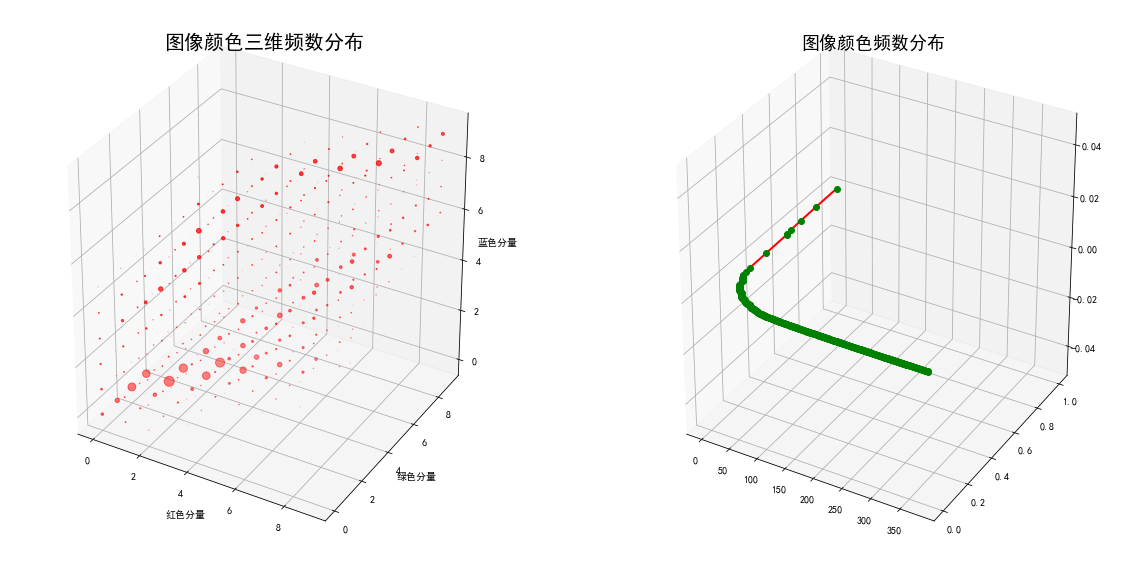

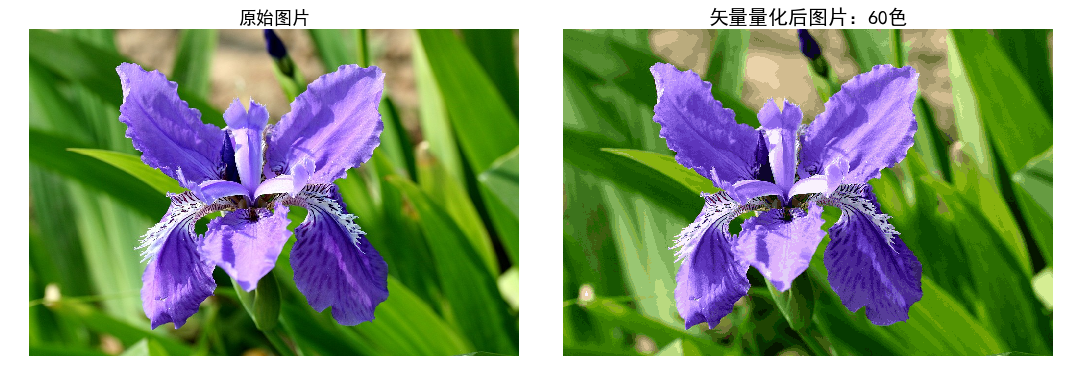

In [3]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
def restore_image(cb, cluster, shape):
    row, col, dummy = shape
    image = np.empty((row, col, 3))
    index = 0
    for r in range(row):
        for c in range(col):
            image[r, c] = cb[cluster[index]]
            index += 1
    return image

def show_scatter(a):
    N = 10
    density, edges = np.histogramdd(a, bins=[N,N,N], range=[(0,1), (0,1), (0,1)])
    density /= density.max()
    x = y = z = np.arange(N)
    d = np.meshgrid(x, y, z)

    fig = plt.figure(figsize=(20,10), facecolor='w')
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(d[1], d[0], d[2], c='r', s=100*density, marker='o', depthshade=True)
    ax.set_xlabel(u'红色分量')
    ax.set_ylabel(u'绿色分量')
    ax.set_zlabel(u'蓝色分量')
    plt.title(u'图像颜色三维频数分布', fontsize=20)

    ax = fig.add_subplot(122, projection='3d')
    den = density[density > 0]
    den = np.sort(den)[::-1]
    t = np.arange(len(den))
    ax.plot(t, den, 'r-', t, den, 'go', lw=2)
    plt.title(u'图像颜色频数分布', fontsize=18)
    plt.grid(True)

matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

num_vq = 60
im = Image.open('data/flower2.png')     # son.bmp(100)/flower2.png(200)/son.png(60)/lena.png(50)
image = np.array(im).astype(np.float) / 255
image = image[:, :, :3]
image_v = image.reshape((-1, 3))
model = KMeans(num_vq)
show_scatter(image_v)

N = image_v.shape[0]    # 图像像素总数
# 选择足够多的样本(如1000个)，计算聚类中心
idx = np.random.randint(0, N, size=1000)
image_sample = image_v[idx]
model.fit(image_sample)
c = model.predict(image_v)  # 聚类结果

plt.figure(figsize=(15, 8), facecolor='w')
plt.subplot(121)
plt.axis('off')
plt.title(u'原始图片', fontsize=18)
plt.imshow(image)

plt.subplot(122)
vq_image = restore_image(model.cluster_centers_, c, image.shape)
plt.axis('off')
plt.title(u'矢量量化后图片：%d色' % num_vq, fontsize=20)
plt.imshow(vq_image)

plt.tight_layout(1.2)

# 2.使用Python Code实现KMeans

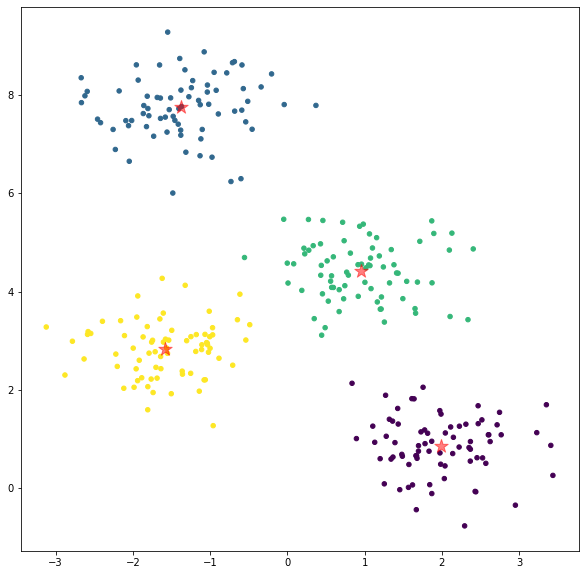

In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
import operator

def get_k_data():
    x, y = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)
    return x, y

def init_board_gauss(N, k):
    from numpy import random
    n = float(N)/k
    X = []
    for i in range(k):
        c = (random.uniform(-1, 1), random.uniform(-1, 1))
        s = random.uniform(0.05, 0.5)
        x = []
        while len(x) < n:
            a, b = np.array([np.random.normal(c[0], s), np.random.normal(c[1], s)])
            # Continue drawing points from the distribution in the range [-1,1]
            if abs(a) < 1 and abs(b) < 1:
                x.append([a, b])
        X.extend(x)
    X = np.array(X)[:N]
    return X

class KMeans(object):
    def __init__(self, k, init_vec, max_iter=100):
        """
        :param k:
        :param init_vec: init mean vectors type: k * n array(n properties)
        """
        self._k = k
        self._cluster_vec = init_vec
        self._max_iter = max_iter

    def fit(self, x):
        for i in range(self._max_iter):
            d_cluster = self._cluster_point(x)
            new_center_node = self._reevaluate_center_node(d_cluster)

            if self._check_converge(new_center_node):
                break
            else:
                self._cluster_vec = new_center_node

    def _cal_distance(self, vec1, vec2):
        return np.linalg.norm(vec1 - vec2)

    def _cluster_point(self, x):
        # 每个簇心对应的簇节点
        lst_cluster_idx = []
        d_cluster = {}

        for x_node in x:
            lst_dis = []
            for c_node in self._cluster_vec:
                d = self._cal_distance(c_node, x_node)
                lst_dis.append(d)
            min_idx, min_dis = min(enumerate(lst_dis), key=operator.itemgetter(1))
            lst_cluster_idx.append(min_idx)

        for i, idx in enumerate(lst_cluster_idx):
            if idx not in d_cluster.keys():
                d_cluster[idx] = np.array([x[i]])
            else:
                d_cluster[idx] = np.append(d_cluster[idx], [x[i]], axis=0)

        return d_cluster

    def _reevaluate_center_node(self, d_cluster):
        arr_center_node = np.empty_like(self._cluster_vec)
        for i, k in enumerate(d_cluster.keys()):
            arr_center_node[i] = np.mean(d_cluster[k], axis=0)

        return arr_center_node

    def _check_converge(self, vec):
        return np.array_equal(self._cluster_vec, vec)

    def get_center_node(self):
        return self._cluster_vec

    def pred(self, arr_data):
        """
        :param arr_data: numpy array
        :return:
        """
        ret_lst_label =[]
        for sample in arr_data:
            lst_d = []
            for node in self._cluster_vec:
                d = self._cal_distance(sample, node)
                lst_d.append(d)

            label, min_d = min(enumerate(lst_d), key=operator.itemgetter(1))
            ret_lst_label.append(label)

        return ret_lst_label

x, y = get_k_data()
k = 4
lst_idx = np.random.randint(x.shape[0], size=k)
init_vec = x[lst_idx]
km = KMeans(k, init_vec)
km.fit(x)
y_hat = km.pred(x)
center_node = km.get_center_node()

plt.figure(figsize=(10,10), facecolor='w')
plt.scatter(x[:, 0], x[:, 1], c=y_hat, s=20)
plt.scatter(center_node[:, 0], center_node[:, 1], marker="*",c='r', s=200, alpha=0.5)

# 3.实现KMeans进行聚类

Text(0.5, 0.98, '数据分布对KMeans聚类的影响')

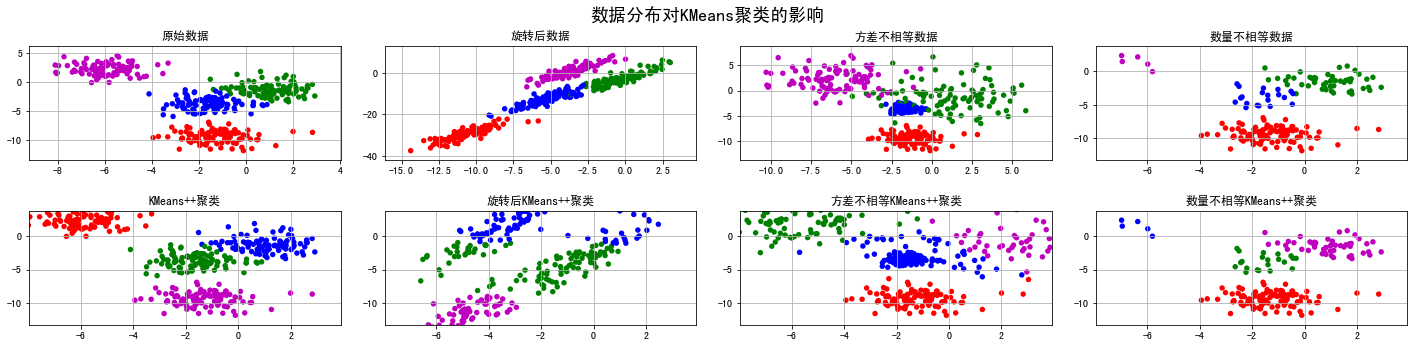

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import matplotlib.colors
from sklearn.cluster import KMeans

def expand(a, b):
    d = (b - a) * 0.1
    return a-d, b+d

N = 400
centers = 4
data, y = ds.make_blobs(N, n_features=2, centers=centers, random_state=2)
data2, y2 = ds.make_blobs(N, n_features=2, centers=centers, cluster_std=(1,2.5,0.5,2), random_state=2)
data3 = np.vstack((data[y == 0][:], data[y == 1][:50], data[y == 2][:20], data[y == 3][:5]))
y3 = np.array([0] * 100 + [1] * 50 + [2] * 20 + [3] * 5)

cls = KMeans(n_clusters=4, init='k-means++')
y_hat = cls.fit_predict(data)
y2_hat = cls.fit_predict(data2)
y3_hat = cls.fit_predict(data3)

m = np.array(((1, 1), (1, 3)))
data_r = data.dot(m)
y_r_hat = cls.fit_predict(data_r)

matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
cm = matplotlib.colors.ListedColormap(list('rgbm'))

plt.figure(figsize=(20, 5), facecolor='w')
plt.subplot(241)
plt.title(u'原始数据')
plt.scatter(data[:, 0], data[:, 1], c=y, s=30, cmap=cm, edgecolors='none')
x1_min, x2_min = np.min(data, axis=0)
x1_max, x2_max = np.max(data, axis=0)
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.grid(True)

plt.subplot(242)
plt.title(u'旋转后数据')
plt.scatter(data_r[:, 0], data_r[:, 1], c=y, s=30, cmap=cm, edgecolors='none')
x1_min, x2_min = np.min(data_r, axis=0)
x1_max, x2_max = np.max(data_r, axis=0)
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.grid(True)

plt.subplot(243)
plt.title(u'方差不相等数据')
plt.scatter(data2[:, 0], data2[:, 1], c=y2, s=30, cmap=cm, edgecolors='none')
x1_min, x2_min = np.min(data2, axis=0)
x1_max, x2_max = np.max(data2, axis=0)
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.grid(True)

plt.subplot(244)
plt.title(u'数量不相等数据')
plt.scatter(data3[:, 0], data3[:, 1], s=30, c=y3, cmap=cm, edgecolors='none')
x1_min, x2_min = np.min(data3, axis=0)
x1_max, x2_max = np.max(data3, axis=0)
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.grid(True)

plt.subplot(245)
plt.title(u'KMeans++聚类')
plt.scatter(data[:, 0], data[:, 1], c=y_hat, s=30, cmap=cm, edgecolors='none')
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.grid(True)

plt.subplot(246)
plt.title(u'旋转后KMeans++聚类')
plt.scatter(data_r[:, 0], data_r[:, 1], c=y_r_hat, s=30, cmap=cm, edgecolors='none')
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.grid(True)

plt.subplot(247)
plt.title(u'方差不相等KMeans++聚类')
plt.scatter(data2[:, 0], data2[:, 1], c=y2_hat, s=30, cmap=cm, edgecolors='none')
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.grid(True)

plt.subplot(248)
plt.title(u'数量不相等KMeans++聚类')
plt.scatter(data3[:, 0], data3[:, 1], c=y3_hat, s=30, cmap=cm, edgecolors='none')
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.grid(True)

plt.tight_layout(2, rect=(0, 0, 1, 0.97))
plt.suptitle(u'数据分布对KMeans聚类的影响', fontsize=18)